# Fys245 Oblig 
### Johan Zapffe og Astrid Moum

grpgfsd


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
import seaborn as sns

## Oppgave 1
Beregn transmissjonskoeffisienten til en partikkel beskrevet som en planbølge. 
Planbølgen har økende energier fra 20 eV.

Trinnpotensial med E > V0. Planbølge kommer inn fra venstre og treffer potensialtrinnet (Sett inn figur?)

Transmisjonskoeffisienten ved E=0.2 eV er 0.854. 
Refleksjonskoeffisienten ved E=0.2 er 0.146


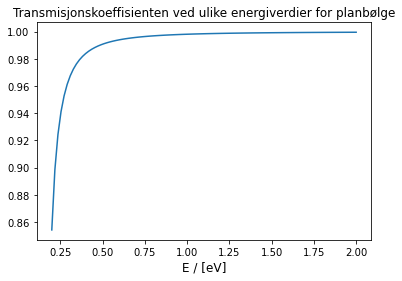

In [4]:
def T(E, V0):
    """
    Funksjon for å kalkulere transmissjonskoeffisienten til en partikkel beskrevet som en planbølge.
    Transmissjonskoeffisienten vil være i intervallet [0,1]. Dette beskriver prosentandelen av bølgen som
    transmitteres
    
    Inputs
    ------
    E - ndarray
        1D numpy array av energier til de innkommende planbølgene
    
    V0 - float
        Den potensielle energien til potensialtrinnet
    
    Returns
    -------
    T - ndarray
        1D numpy array av transmisjonskoeffisientene. I intervallet [0,1]
    
    """
    h_bar = 6.582 * 1e-16  # [eV*s]
    m = 9.11 * 1e-31  # mass of electron [kg]
    k = np.sqrt(2*m*E) / h_bar
    k0 = np.sqrt(2*m*(E-V0)) / h_bar
    T = (4*k*k0)/(k+k0)**2
    
    return T

def R(E, V0):
    """
    Funksjon for å kalkulere refleksjonskoeffisienten til en partikkel beskrevet som en planbølge.
    Refleksjonskoeffisienten vil være i intervallet [0,1]. Dette beskriver prosentandelen av bølgen som
    reflekteres
    
    Inputs
    ------
    E - ndarray
        1D numpy array av energier til de innkommende planbølgene
    
    V0 - float
        Den potensielle energien til potensialtrinnet
    
    Returns
    -------
    R - ndarray
        1D numpy array av refleksjonskoeffisientene. I intervallet [0,1]
    
    """
    h_bar = 6.582 * 1e-16  # [eV*s]
    m = 9.11 * 1e-31  # mass of electron [kg]
    k = np.sqrt(2*m*E) / h_bar
    k0 = np.sqrt(2*m*(E-V0)) / h_bar
    R = (k - k0)**2/(k+k0)**2
    
    return R


# ===============================
# Beregner transmisjons- og refleksjonskoeffisienten for E=0.20 eV
# ===============================
E = 0.20  # eV
V0 = 0.16  # [eV]
T_coeff = T(E, V0)
R_coeff = R(E, V0)
R_coeff2 = 1-T_coeff  #ER DETTE NOK?

assert R_coeff.round(5) == R_coeff2.round(5), "The reflection coefficient should be equal whether \
                                                you calculate it by the formula R(E, V0) or  1-T"


print(f'Transmisjonskoeffisienten ved E={E} eV er {T_coeff.round(3)}. \nRefleksjonskoeffisienten ved E={E} er {R_coeff.round(3)}')

# ================================
# Energi høyere enn potensialet
# ================================
E = np.linspace(0.20, 2, 100)  # [eV]
V0 = 0.16  # [eV]

# Lager et plot av transmissjonskoeffisienten ved ulike verdier for energi
plt.plot(E, T(E,V0))
plt.title("Transmisjonskoeffisienten ved ulike energiverdier for planbølge")
plt.xlabel("E / [eV]", fontsize=12)
plt.show()

In [ ]:
# ============================
# Energi lavere enn potensialet
# ============================



## Oppgave 2


### Bølgepakken

In [5]:
# ==========
# Se bort fra denne cellen
# ==========

#sigma = 1* 1e-8  # [m]
#E = 0.20  # [eV]
#V0 = 0.16  # [eV]
#m = 9.11 * 1e-31  # [kg]
#x0 = 50 * 1e-9  # [m]
#L = 200 * 1e-9  # [m]
#h_bar = 6.582 * 1e-16  # [eV*s]
#
#t = 0
#dt = 2.25 * 1e-19  # [s]
#dx = 1.5 * 1e-10  # [m]
#
#def V(x):
#    """
#    The potential energy of the particle. Will be infinite 
#    
#    Returns:
#    --------
#    float
#        The potential energy of the particle   
#    """
#    inf=math.exp(15)
#    
#    V_list = []
#    
#    for xi in x:
#        if xi <= 0 or xi >= L:
#            V_list.append(inf)
#        elif 0 < xi < L/2:
#            V_list.append(0)
#        else:
#            V_list.append(V0)
#    return V_list
#
##def Phi(x, x0, t, dt, dx):
##    """
##    Funksjon for å regne ut det neste tidssteget til den tidsavhengige bølgepakken
##    
##    Inputs
##    ------
##    x - nparray
##        Posisjonen til bølgepakken (?)
##    
##    x0 - float
##        Startpunktet for posisjonen til bølgepakken
##        
##    t - float
##        Tispunktet for forrige observerte bølgepakke
##    
##    dt - float
##        Størrelsen på tidsintervallet vi observerer
##    
##    dx - float
##        Størrelsen på posisjonsintervallet vi observerer
##    
##    Returns
##    -------
##    neste_tidssteg - float
##        bølgepakken for neste tidssteg
##    
##    See Also
##    --------
##    ksi(x, t)
##        Den tidsavhengige bølgefunksjonen
##    """
##    scnd_d_x = ksi(x+dx, x0, t) - 2*ksi(x, x0, t) + ksi(x-dx, x0, t) / dx**2  # Den andre deriverte av ksi mhp x
##    neste_tidssteg = ksi(x, x0, t) + dt/(1j*h_bar) * ((-h_bar**2 * scnd_d_x/2*m) + ksi(x, x0, t) * V(x))
##    
##    return neste_tidssteg
#
#def Phi_neste_tidssteg(x, x0, t_slutt, dt, dx):
#    """
#    Funksjon for å regne ut det neste tidssteget til den tidsavhengige bølgepakken
#    
#    Inputs
#    ------
#    x - nparray
#        Posisjonen til bølgepakken (?)
#    
#    x0 - float
#        Startpunktet for posisjonen til bølgepakken
#        
#    t_slutt - float
#        Tispunktet for forrige observerte bølgepakke
#    
#    dt - float
#        Størrelsen på tidsintervallet vi observerer
#    
#    dx - float
#        Størrelsen på posisjonsintervallet vi observerer
#    
#    Returns
#    -------
#    neste_tidssteg - float
#        bølgepakken for neste tidssteg
#    
#    See Also
#    --------
#    ksi(x, t)
#        Den tidsavhengige bølgefunksjonen
#    """
#    Phi_neste_tidssteg = []
#    
#    # Starter i t = \delta t. Den er avhengig av Phi(x, 0) - bølgepakken i t = 0. Denne er gitt ved likning 4 (manual) / 9 (vår likning)
#    Phi_forrige_tidssteg = ksi(x, x0)
#    
#    
#    #for t in np.linspace(dt, t_slutt, int((t_slutt - dt)/dt)): # Takes up too much memory
#    for t in np.linspace(dt, t_slutt, 1000): # Takes up too much memory
#    # For hvert tidssteg skal trinnpotensialet regnes ut for alle x. Phi(0) og Phi(L) må settes ved hvert tidssteg
#    
#        Phi = f(Phi_forrige_tidssteg, x)
#        Phi_neste_tidssteg.append(Phi)
#
#        # Setter den utregnede verdien til Phi lik Phi_forrige_tidssteg for å gjøre klart for ny utregning av Phi
#        Phi_forrige_tidssteg = Phi
#    
#    
#    return Phi_neste_tidssteg
#
#def f(Phi_forrige_tidssteg, x):
#    """
#    Funksjon for å regne ut ny verdi av Phi som en funksjon av forrige verdi av Phi
#    
#    Inputs
#    ------
#    Phi_forrige_tidssteg - nparray
#        Verdier for Phi ved forrige tidssteg
#    
#    Returns
#    -------
#    Phi - nparray
#        Nye verdier for Phi
#    """
#    
#    pluss_dx = np.append(Phi_forrige_tidssteg[1:], [0])
#    print(len(pluss_dx))
#    minus_dx = np.append([0], Phi_forrige_tidssteg[:-1])
#    print(len(minus_dx))
#    print(len(2*Phi_forrige_tidssteg))
#    #pluss_dx = Phi_forrige_tidssteg[1:]
#    #minus_dx = Phi_forrige_tidssteg[:-1]
#    
#    #scnd_d_x = pluss_dx - 2*Phi_forrige_tidssteg + minus_dx / dx**2  # Den andre deriverte av ksi mhp x
#    
#    
#    #Phi = Phi_forrige_tidssteg + dt/(1j*h_bar) * ((-h_bar**2 * scnd_d_x/2*m) + Phi_forrige_tidssteg * V(x))
#    
#   # Phi = []
#   # for i, xi in enumerate(x):
#   #     if xi == 0 or xi == L:
#   #         Phi.append(0)
#   #     else:
#   #         scnd_d_x = Phi_forrige_tidssteg[i+1] - 2*Phi_forrige_tidssteg[i] + Phi_forrige_tidssteg[i-1] / dx**2  # Den andre deriverte av ksi mhp x
#   #        
#   #         Phi.append(Phi_forrige_tidssteg[i] + dt/(1j*h_bar) * ((-h_bar**2 * scnd_d_x/2*m) + Phi_forrige_tidssteg[i] * V(x)))
#   #     
#   return  Phi
#
##def ksi2(x, x0, t):
##    """
##    Den stasjonære bølgepakken (tidsavhengig)
##    
##    Inputs
##    ------
##    x - nparray
##        Posisjonen til bølgepakken (?)
##    
##    x0 - float
##        Startpunktet for posisjonen til bølgepakken
##    
##    t - float
##        Tiden som vi observerer bølgepakken ved
##    
##    Returns
##    -------
##    float
##        stasjonær bølgepakke
##    """
##    k = np.sqrt(2*m*E) / h_bar
##    time_dependent_ksi = np.exp(1j*E*t/h_bar)
##    return (1 / (np.pi**(1/4) * np.sqrt(sigma))) * np.exp(-((x-x0)**2 / (2*sigma**2))) * np.exp(1j*k*(x-x0)) * time_dependent_ksi
#
#def ksi(x, x0):
#    """
#    Den stasjonære bølgepakken (tidsavhengig)
#    
#    Inputs
#    ------
#    x - nparray
#        Posisjonen til bølgepakken (?)
#    
#    x0 - float
#        Startpunktet for posisjonen til bølgepakken
#    
#    Returns
#    -------
#    float
#        stasjonær bølgepakke
#    """
#    k = np.sqrt(2*m*E) / h_bar
#    return (1 / (np.pi**(1/4) * np.sqrt(sigma))) * np.exp(-((x-x0)**2 / (2*sigma**2))) * np.exp(1j*k*(x-x0))
#
#
#x = np.linspace(0, L, 100)
#t = 0
#hei = ksi(x, x0)
##print(hei[:])
##print(hei[:-1]) # kutter det siste leddet
##print(hei[1:]) # kutter ut det første leddet
##plt.plot(hei)
#
#for _ in range(50):
#    #hei = ksi(x, x0, t)
#    #print(hei)
#    t+= dt
#    
#t = 1 * 1e-3
#hei = Phi_neste_tidssteg(x, x0, t, dt, dx)
#print(hei)
#print(hei[0])
#print(hei[999])
#plt.plot(hei[0]) # plotter bølgefunksjonen ved t = 0
#plt.show()
#plt.plot(hei[10])
#
#for xi in x:
#    t += dt
#    #print(xi)
#    #hei = ksi(xi, x0, t)
#    #print(hei)
#    #hei2 = Phi_neste_tidssteg(x, x0, t, dt, dx)
#    #print(hei2)

In [3]:
sigma = 1* 1e-8  # [m]
E = 0.20 * 1.602 * 1e-19 # [eV]
V0 = 0.16  * 1.602 * 1e-19 # [eV]
m = 9.11 * 1e-31  # [kg]
x0 = 50 * 1e-9  # [m]
L = 200 * 1e-9  # [m]
h_bar = 1.055 * 1e-34 # [eV*s]

t = 0
dt = 2.25 * 1e-19  # [s]
dx = 1.5 * 1e-10  # [m]

def V(x):
    """
    The potential energy of the particle. Will be infinite 
    
    Returns:
    --------
    float
        The potential energy of the particle   
    """
    inf=math.exp(15)
    
    V_list = []
    
    for xi in x:
        if xi <= 0 or xi >= L:
            V_list.append(inf)
        elif 0 < xi < L/2:
            V_list.append(0)
        else:
            V_list.append(V0)
    return V_list

def Phi_neste_tidssteg0(x, x0, t_slutt, dt, dx):
    """
    Funksjon for å regne ut det neste tidssteget til den tidsavhengige bølgepakken
    
    Inputs
    ------
    x - nparray
        Posisjonen til bølgepakken (?)
    
    x0 - float
        Startpunktet for posisjonen til bølgepakken
        
    t_slutt - float
        Tispunktet for forrige observerte bølgepakke
    
    dt - float
        Størrelsen på tidsintervallet vi observerer
    
    dx - float
        Størrelsen på posisjonsintervallet vi observerer
    
    Returns
    -------
    neste_tidssteg - float
        bølgepakken for neste tidssteg
    
    See Also
    --------
    ksi(x, t)
        Den tidsavhengige bølgefunksjonen
    """
    Phi_neste_tidssteg = []
    
    # Starter i t = \delta t. Den er avhengig av Phi(x, 0) - bølgepakken i t = 0. Denne er gitt ved likning 4 (manual) / 9 (vår likning)
    Phi_forrige_tidssteg = ksi(x, x0)
    
    
    for t in np.linspace(dt, t_slutt, int((t_slutt - dt)/dt)): # Takes up too much memory
    #for t in np.linspace(dt, t_slutt, 1000): # Takes up too much memory
    # For hvert tidssteg skal trinnpotensialet regnes ut for alle x. 
    
        Phi = f(Phi_forrige_tidssteg, x)
        Phi_neste_tidssteg.append(Phi)

        # Setter den utregnede verdien til Phi lik Phi_forrige_tidssteg for å gjøre klart for ny utregning av Phi
        Phi_forrige_tidssteg = Phi
    
    
    return Phi_neste_tidssteg

def Phi_neste_tidssteg(x, x0, t_slutt, dt, dx):
    """
    Funksjon for å regne ut det neste tidssteget til den tidsavhengige bølgepakken
    
    Inputs
    ------
    x - nparray
        Posisjonen til bølgepakken (?)
    
    x0 - float
        Startpunktet for posisjonen til bølgepakken
        
    t_slutt - float
        Tispunktet for forrige observerte bølgepakke
    
    dt - float
        Størrelsen på tidsintervallet vi observerer
    
    dx - float
        Størrelsen på posisjonsintervallet vi observerer
    
    Returns
    -------
    neste_tidssteg - float
        bølgepakken for neste tidssteg
    
    See Also
    --------
    ksi(x, t)
        Den tidsavhengige bølgefunksjonen
    """
    num_steps = int((t_slutt - dt)/dt)
    #Phi_neste_tidssteg = []
    Phi_neste_tidssteg = np.zeros((num_steps, len(x)), dtype=complex)
    
    # Starter i t = \delta t. Den er avhengig av Phi(x, 0) - bølgepakken i t = 0. Denne er gitt ved likning 4 (manual) / 9 (vår likning)
    Phi_forrige_tidssteg = ksi(x, x0)
    
    
    for i, t in enumerate(np.linspace(dt, t_slutt, num_steps-1000)): # Takes up too much memory
    #for t in np.linspace(dt, t_slutt, 1000): # Takes up too much memory
    # For hvert tidssteg skal trinnpotensialet regnes ut for alle x. 
    
        Phi = f(Phi_forrige_tidssteg, x)
        Phi_neste_tidssteg[i] = Phi

        # Setter den utregnede verdien til Phi lik Phi_forrige_tidssteg for å gjøre klart for ny utregning av Phi
        Phi_forrige_tidssteg = Phi
    
    
    return Phi_neste_tidssteg


def f(Phi_forrige_tidssteg, x):
    """
    Funksjon for å regne ut ny verdi av Phi som en funksjon av forrige verdi av Phi
    
    Inputs
    ------
    Phi_forrige_tidssteg - nparray
        Verdier for Phi ved forrige tidssteg
    
    Returns
    -------
    Phi - nparray
        Nye verdier for Phi
    """
    
    #pluss_dx = np.append(Phi_forrige_tidssteg[1:], [0])
    #minus_dx = np.append([0], Phi_forrige_tidssteg[:-1])
    
    # Regn ut den dobbeltderiverte kun for godkjente verdier
    pluss_dx = Phi_forrige_tidssteg[2:]
    minus_dx = Phi_forrige_tidssteg[:-2]
    scnd_d_x = (pluss_dx - 2*Phi_forrige_tidssteg[1:-1] + minus_dx) / dx**2  # Den andre deriverte av ksi mhp x
    
    # ==============
    # Regn ut Phi
    # ==============
    # Regner ut Phi, men ser bort ifra de ytterste verdiene ved Phi(0) og Phi(L)
    Phi = Phi_forrige_tidssteg[1:-1] + dt/(1j*h_bar) * ((-h_bar**2 * scnd_d_x/(2*m)) + Phi_forrige_tidssteg[1:-1] * V(x)[1:-1])
    
    # Setter Phi(0) og Phi(L) til 0
    Phi = np.append(Phi, 0)
    Phi = np.insert(Phi, 0, 0, axis=0)
    
    return  Phi


def ksi(x, x0):
    """
    Den stasjonære bølgepakken (tidsavhengig)
    
    Inputs
    ------
    x - nparray
        Posisjonen til bølgepakken (?)
    
    x0 - float
        Startpunktet for posisjonen til bølgepakken
    
    Returns
    -------
    float
        stasjonær bølgepakke
    """
    k = np.sqrt(2*m*E) / h_bar
    #return (1 / (np.pi**(1/4) * np.sqrt(sigma))) * np.exp(-((x-x0)**2 / (2*sigma**2))) * np.exp(1j*k*(x-x0))
    return (1 / (np.pi**(1/4) * np.sqrt(sigma))) * np.exp(-((x-x0)**2 / (2*sigma**2)) + 1j*k*(x-x0))


x = np.linspace(0, L, 100)
#t = 1 * 1e-13
# hei = Phi_neste_tidssteg(x, x0, t, dt, dx)
# #print(hei)
# print(hei[0])
# print(hei[999])
# plt.plot(hei[0]) # plotter bølgefunksjonen ved t = 0
# plt.show()
# plt.plot(hei[999])
# plt.show()

In [ ]:
# plt.plot(hei[-1])
# plt.show()
#
# plt.plot(hei[-1].imag)

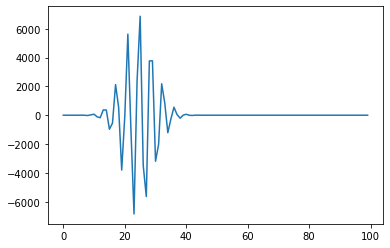

In [4]:
def plot_ksi(t):
    """
    Funksjon for å plotte bølgefunksjonen ksi ved gitt tidspunkt
    
    Inputs
    ------
    t - float
        Tiden vi ønsker å plotte bølgefunksjonen ved
    
    Returns
    -------
        plot av bølgefunksjonen ved gitt tidspunkt
    """
    pass

ff = ksi(x, x0)
plt.plot(ff.imag)
plt.show()

f3 = Phi_neste_tidssteg(x, x0, dt*100000, dt, dx)



C:\Users\astri\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\astri\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


99999


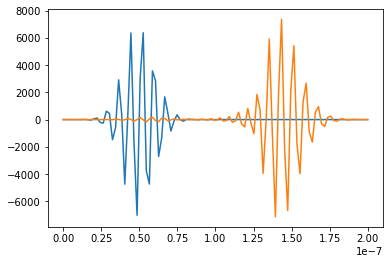

In [10]:
fig, ax = plt.subplots()
ax.plot(x, f3[0])
print(len(f3))
ax.plot(x, f3[-16000])
#print(f3[8])
plt.show()


Uttrykket psi I, hva skal det bygge på? Skal det komme av likning 1? Skal det kombineres med likning 4?






## Oppgave 3
Undersøkelse av hvordan innfallsvinkel påvirker nnsynligheten for at elektroner blir transmittert.
Systemet blir beskrevet vha planbølge


Beregne T(E, alpha)

In [ ]:
V0 = 0.16  # [eV]
E = np.linspace(0.4, 0.2, 10)  # eV
alpha = np.linspace(0, 30, 10)  # degrees


#E = 0.2
#alpha = 0
m = 9.11 * 1e-31  # mass of electron [kg]
h_bar = 6.582 * 1e-16  # [eV*s]

In [ ]:
def T(E, V0, alpha):
    """
    Funksjon for å beregne transmisjonskoeffisienten avhengig av energien og
    og innfallsvinkelen til planbølgen. Vil være i intervallet [0,1]
    
    Inputs
    ------
    E - float
        Energi til planbølgen
    V0- float
        Den potensielle energien til potensialtrinnet
    alpha - float
        Innfallsvinkel til planbølgen
    
    Returns
    -------
    float
        Transmisjonskoeffisienten til planbølgen
    """
    T = np.zeros([len(E), len(alpha)])
    _alpha = np.deg2rad(alpha)
    
    for i, _E in enumerate(E):
        k = np.sqrt(2*m*_E) / h_bar  # likn 9
        k_y = k * np.sin(_alpha)  # likn 12
    
        k0_2 = (np.sqrt(2*m*(_E-V0)) / h_bar) **2
        k0_x = np.sqrt(k0_2 - k_y**2)
        k0 = np.sqrt(k0_x**2 + k_y**2)
    
        T[i] = 4 * k * k0 / (k + k0) ** 2
    
    return T

def R(E, alpha):
    """
    Funksjon for å beregne refleksjonskoeffisienten avhengig av energien og
    og innfallsvinkelen til planbølgen. Vil være i intervallet [0,1]
    
    Inputs
    ------
    E - float
        Energi til planbølgen [eV]
    alpha - float
        Innfallsvinkel til planbølgen [grader]
    
    Returns
    -------
    float
        Refleksjonskoeffisienten til planbølgen
    """
    pass

# Regne ut transmisjonskoeffisienten for energi- og alpha-verdier
T_values = T(E, V0, alpha)

# Plotte transmisjonskoeffisienten
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(data=T_values, annot=True, fmt='.4g', xticklabels=alpha.round(2), yticklabels=E.round(2))
ax.set(xlabel=r'$\alpha [\degree]$', ylabel='Energy [eV]', title='Transmisjonskoeffisienten for planbølger med ulik energi og innfallsvinkel')
plt.show()

Når alpha har høy verdi (eks 30 grader) og energien til bølgepakken er lav (eks 0.2 eV) vil utregningen av k0_x gi
NaN. 
k0_x = np.sqrt(k0_2 - k_y ** 2)

Dette er fordi k0^2 - ky^2 < 0. Dermed får vi noe negativt under rottegn.

I praksis betyr dette at for tilstrekkelig høye vinklerer sannsynligheten for at partikkelen transmitteres lik 0. Det er dermed totalrefleksjon for disse vinklene

# SPØRSMÅL ONSDAG:
I praksis så vil det si at alt reflekteres og ingenting transmitteres(?). Teoretisk sett, hva vil det si at vi får et komplekst tall for transmisjonskoeffisienten?

Hvem har skrevet teksten til obligen?? (mtp kilde)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
import seaborn as sns

## Oppgave 1
Beregn transmissjonskoeffisienten til en partikkel beskrevet som en planbølge. 
Planbølgen har økende energier fra 20 eV.

Trinnpotensial med E > V0. Planbølge kommer inn fra venstre og treffer potensialtrinnet (Sett inn figur?)

Transmisjonskoeffisienten ved E=0.2 eV er 0.854. 
Refleksjonskoeffisienten ved E=0.2 er 0.146


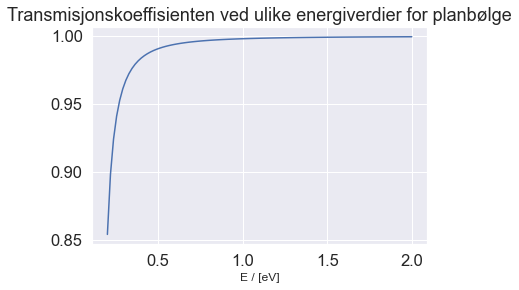

In [11]:
def T(E, V0):
    """
    Funksjon for å kalkulere transmissjonskoeffisienten til en partikkel beskrevet som en planbølge.
    Transmissjonskoeffisienten vil være i intervallet [0,1]. Dette beskriver prosentandelen av bølgen som
    transmitteres
    
    Inputs
    ------
    E - ndarray
        1D numpy array av energier til de innkommende planbølgene
    
    V0 - float
        Den potensielle energien til potensialtrinnet
    
    Returns
    -------
    T - ndarray
        1D numpy array av transmisjonskoeffisientene. I intervallet [0,1]
    
    """
    h_bar = 6.582 * 1e-16  # [eV*s]
    m = 9.11 * 1e-31  # mass of electron [kg]
    k = np.sqrt(2*m*E) / h_bar
    k0 = np.sqrt(2*m*(E-V0)) / h_bar
    T = (4*k*k0)/(k+k0)**2
    
    return T

def R(E, V0):
    """
    Funksjon for å kalkulere refleksjonskoeffisienten til en partikkel beskrevet som en planbølge.
    Refleksjonskoeffisienten vil være i intervallet [0,1]. Dette beskriver prosentandelen av bølgen som
    reflekteres
    
    Inputs
    ------
    E - ndarray
        1D numpy array av energier til de innkommende planbølgene
    
    V0 - float
        Den potensielle energien til potensialtrinnet
    
    Returns
    -------
    R - ndarray
        1D numpy array av refleksjonskoeffisientene. I intervallet [0,1]
    
    """
    h_bar = 6.582 * 1e-16  # [eV*s]
    m = 9.11 * 1e-31  # mass of electron [kg]
    k = np.sqrt(2*m*E) / h_bar
    k0 = np.sqrt(2*m*(E-V0)) / h_bar
    R = (k - k0)**2/(k+k0)**2
    
    return R


# ===============================
# Beregner transmisjons- og refleksjonskoeffisienten for E=0.20 eV
# ===============================
E = 0.20  # eV
V0 = 0.16  # [eV]
T_coeff = T(E, V0)
R_coeff = R(E, V0)
R_coeff2 = 1-T_coeff  #ER DETTE NOK?

assert R_coeff.round(5) == R_coeff2.round(5), "The reflection coefficient should be equal whether \
                                                you calculate it by the formula R(E, V0) or  1-T"


print(f'Transmisjonskoeffisienten ved E={E} eV er {T_coeff.round(3)}. \nRefleksjonskoeffisienten ved E={E} er {R_coeff.round(3)}')

# ================================
# Energi høyere enn potensialet
# ================================
E = np.linspace(0.20, 2, 100)  # [eV]
V0 = 0.16  # [eV]

# Lager et plot av transmissjonskoeffisienten ved ulike verdier for energi
plt.plot(E, T(E,V0))
plt.title("Transmisjonskoeffisienten ved ulike energiverdier for planbølge")
plt.xlabel("E / [eV]", fontsize=12)
plt.show()

In [3]:
# ============================
# Energi lavere enn potensialet
# ============================



## Oppgave 2


### Bølgepakken

In [12]:
# ==========
# Se bort fra denne cellen
# ==========

#sigma = 1* 1e-8  # [m]
#E = 0.20  # [eV]
#V0 = 0.16  # [eV]
#m = 9.11 * 1e-31  # [kg]
#x0 = 50 * 1e-9  # [m]
#L = 200 * 1e-9  # [m]
#h_bar = 6.582 * 1e-16  # [eV*s]
#
#t = 0
#dt = 2.25 * 1e-19  # [s]
#dx = 1.5 * 1e-10  # [m]
#
#def V(x):
#    """
#    The potential energy of the particle. Will be infinite 
#    
#    Returns:
#    --------
#    float
#        The potential energy of the particle   
#    """
#    inf=math.exp(15)
#    
#    V_list = []
#    
#    for xi in x:
#        if xi <= 0 or xi >= L:
#            V_list.append(inf)
#        elif 0 < xi < L/2:
#            V_list.append(0)
#        else:
#            V_list.append(V0)
#    return V_list
#
##def Phi(x, x0, t, dt, dx):
##    """
##    Funksjon for å regne ut det neste tidssteget til den tidsavhengige bølgepakken
##    
##    Inputs
##    ------
##    x - nparray
##        Posisjonen til bølgepakken (?)
##    
##    x0 - float
##        Startpunktet for posisjonen til bølgepakken
##        
##    t - float
##        Tispunktet for forrige observerte bølgepakke
##    
##    dt - float
##        Størrelsen på tidsintervallet vi observerer
##    
##    dx - float
##        Størrelsen på posisjonsintervallet vi observerer
##    
##    Returns
##    -------
##    neste_tidssteg - float
##        bølgepakken for neste tidssteg
##    
##    See Also
##    --------
##    ksi(x, t)
##        Den tidsavhengige bølgefunksjonen
##    """
##    scnd_d_x = ksi(x+dx, x0, t) - 2*ksi(x, x0, t) + ksi(x-dx, x0, t) / dx**2  # Den andre deriverte av ksi mhp x
##    neste_tidssteg = ksi(x, x0, t) + dt/(1j*h_bar) * ((-h_bar**2 * scnd_d_x/2*m) + ksi(x, x0, t) * V(x))
##    
##    return neste_tidssteg
#
#def Phi_neste_tidssteg(x, x0, t_slutt, dt, dx):
#    """
#    Funksjon for å regne ut det neste tidssteget til den tidsavhengige bølgepakken
#    
#    Inputs
#    ------
#    x - nparray
#        Posisjonen til bølgepakken (?)
#    
#    x0 - float
#        Startpunktet for posisjonen til bølgepakken
#        
#    t_slutt - float
#        Tispunktet for forrige observerte bølgepakke
#    
#    dt - float
#        Størrelsen på tidsintervallet vi observerer
#    
#    dx - float
#        Størrelsen på posisjonsintervallet vi observerer
#    
#    Returns
#    -------
#    neste_tidssteg - float
#        bølgepakken for neste tidssteg
#    
#    See Also
#    --------
#    ksi(x, t)
#        Den tidsavhengige bølgefunksjonen
#    """
#    Phi_neste_tidssteg = []
#    
#    # Starter i t = \delta t. Den er avhengig av Phi(x, 0) - bølgepakken i t = 0. Denne er gitt ved likning 4 (manual) / 9 (vår likning)
#    Phi_forrige_tidssteg = ksi(x, x0)
#    
#    
#    #for t in np.linspace(dt, t_slutt, int((t_slutt - dt)/dt)): # Takes up too much memory
#    for t in np.linspace(dt, t_slutt, 1000): # Takes up too much memory
#    # For hvert tidssteg skal trinnpotensialet regnes ut for alle x. Phi(0) og Phi(L) må settes ved hvert tidssteg
#    
#        Phi = f(Phi_forrige_tidssteg, x)
#        Phi_neste_tidssteg.append(Phi)
#
#        # Setter den utregnede verdien til Phi lik Phi_forrige_tidssteg for å gjøre klart for ny utregning av Phi
#        Phi_forrige_tidssteg = Phi
#    
#    
#    return Phi_neste_tidssteg
#
#def f(Phi_forrige_tidssteg, x):
#    """
#    Funksjon for å regne ut ny verdi av Phi som en funksjon av forrige verdi av Phi
#    
#    Inputs
#    ------
#    Phi_forrige_tidssteg - nparray
#        Verdier for Phi ved forrige tidssteg
#    
#    Returns
#    -------
#    Phi - nparray
#        Nye verdier for Phi
#    """
#    
#    pluss_dx = np.append(Phi_forrige_tidssteg[1:], [0])
#    print(len(pluss_dx))
#    minus_dx = np.append([0], Phi_forrige_tidssteg[:-1])
#    print(len(minus_dx))
#    print(len(2*Phi_forrige_tidssteg))
#    #pluss_dx = Phi_forrige_tidssteg[1:]
#    #minus_dx = Phi_forrige_tidssteg[:-1]
#    
#    #scnd_d_x = pluss_dx - 2*Phi_forrige_tidssteg + minus_dx / dx**2  # Den andre deriverte av ksi mhp x
#    
#    
#    #Phi = Phi_forrige_tidssteg + dt/(1j*h_bar) * ((-h_bar**2 * scnd_d_x/2*m) + Phi_forrige_tidssteg * V(x))
#    
#   # Phi = []
#   # for i, xi in enumerate(x):
#   #     if xi == 0 or xi == L:
#   #         Phi.append(0)
#   #     else:
#   #         scnd_d_x = Phi_forrige_tidssteg[i+1] - 2*Phi_forrige_tidssteg[i] + Phi_forrige_tidssteg[i-1] / dx**2  # Den andre deriverte av ksi mhp x
#   #        
#   #         Phi.append(Phi_forrige_tidssteg[i] + dt/(1j*h_bar) * ((-h_bar**2 * scnd_d_x/2*m) + Phi_forrige_tidssteg[i] * V(x)))
#   #     
#   return  Phi
#
##def ksi2(x, x0, t):
##    """
##    Den stasjonære bølgepakken (tidsavhengig)
##    
##    Inputs
##    ------
##    x - nparray
##        Posisjonen til bølgepakken (?)
##    
##    x0 - float
##        Startpunktet for posisjonen til bølgepakken
##    
##    t - float
##        Tiden som vi observerer bølgepakken ved
##    
##    Returns
##    -------
##    float
##        stasjonær bølgepakke
##    """
##    k = np.sqrt(2*m*E) / h_bar
##    time_dependent_ksi = np.exp(1j*E*t/h_bar)
##    return (1 / (np.pi**(1/4) * np.sqrt(sigma))) * np.exp(-((x-x0)**2 / (2*sigma**2))) * np.exp(1j*k*(x-x0)) * time_dependent_ksi
#
#def ksi(x, x0):
#    """
#    Den stasjonære bølgepakken (tidsavhengig)
#    
#    Inputs
#    ------
#    x - nparray
#        Posisjonen til bølgepakken (?)
#    
#    x0 - float
#        Startpunktet for posisjonen til bølgepakken
#    
#    Returns
#    -------
#    float
#        stasjonær bølgepakke
#    """
#    k = np.sqrt(2*m*E) / h_bar
#    return (1 / (np.pi**(1/4) * np.sqrt(sigma))) * np.exp(-((x-x0)**2 / (2*sigma**2))) * np.exp(1j*k*(x-x0))
#
#
#x = np.linspace(0, L, 100)
#t = 0
#hei = ksi(x, x0)
##print(hei[:])
##print(hei[:-1]) # kutter det siste leddet
##print(hei[1:]) # kutter ut det første leddet
##plt.plot(hei)
#
#for _ in range(50):
#    #hei = ksi(x, x0, t)
#    #print(hei)
#    t+= dt
#    
#t = 1 * 1e-3
#hei = Phi_neste_tidssteg(x, x0, t, dt, dx)
#print(hei)
#print(hei[0])
#print(hei[999])
#plt.plot(hei[0]) # plotter bølgefunksjonen ved t = 0
#plt.show()
#plt.plot(hei[10])
#
#for xi in x:
#    t += dt
#    #print(xi)
#    #hei = ksi(xi, x0, t)
#    #print(hei)
#    #hei2 = Phi_neste_tidssteg(x, x0, t, dt, dx)
#    #print(hei2)

In [ ]:
sigma = 1* 1e-8  # [m]
E = 0.20 * 1.602 * 1e-19 # [eV]
V0 = 0.16  * 1.602 * 1e-19 # [eV]
m = 9.11 * 1e-31  # [kg]
x0 = 50 * 1e-9  # [m]
L = 200 * 1e-9  # [m]
h_bar = 1.055 * 1e-34 # [eV*s]

t = 0
dt = 2.25 * 1e-19  # [s]
dx = 1.5 * 1e-10  # [m]

def V(x):
    """
    The potential energy of the particle. Will be infinite 
    
    Returns:
    --------
    float
        The potential energy of the particle   
    """
    inf=math.exp(15)
    
    V_list = []
    
    for xi in x:
        if xi <= 0 or xi >= L:
            V_list.append(inf)
        elif 0 < xi < L/2:
            V_list.append(0)
        else:
            V_list.append(V0)
    return V_list

def Phi_neste_tidssteg(x, x0, t_slutt, dt, dx):
    """
    Funksjon for å regne ut det neste tidssteget til den tidsavhengige bølgepakken
    
    Inputs
    ------
    x - nparray
        Posisjonen til bølgepakken (?)
    
    x0 - float
        Startpunktet for posisjonen til bølgepakken
        
    t_slutt - float
        Tispunktet for forrige observerte bølgepakke
    
    dt - float
        Størrelsen på tidsintervallet vi observerer
    
    dx - float
        Størrelsen på posisjonsintervallet vi observerer
    
    Returns
    -------
    neste_tidssteg - float
        bølgepakken for neste tidssteg
    
    See Also
    --------
    ksi(x, t)
        Den tidsavhengige bølgefunksjonen
    """
    Phi_neste_tidssteg = []
    
    # Starter i t = \delta t. Den er avhengig av Phi(x, 0) - bølgepakken i t = 0. Denne er gitt ved likning 4 (manual) / 9 (vår likning)
    Phi_forrige_tidssteg = ksi(x, x0)
    
    
    for t in np.linspace(dt, t_slutt, int((t_slutt - dt)/dt)): # Takes up too much memory
    #for t in np.linspace(dt, t_slutt, 1000): # Takes up too much memory
    # For hvert tidssteg skal trinnpotensialet regnes ut for alle x. 
    
        Phi = f(Phi_forrige_tidssteg, x)
        Phi_neste_tidssteg.append(Phi)

        # Setter den utregnede verdien til Phi lik Phi_forrige_tidssteg for å gjøre klart for ny utregning av Phi
        Phi_forrige_tidssteg = Phi
    
    
    return Phi_neste_tidssteg


def f(Phi_forrige_tidssteg, x):
    """
    Funksjon for å regne ut ny verdi av Phi som en funksjon av forrige verdi av Phi
    
    Inputs
    ------
    Phi_forrige_tidssteg - nparray
        Verdier for Phi ved forrige tidssteg
    
    Returns
    -------
    Phi - nparray
        Nye verdier for Phi
    """
    
    #pluss_dx = np.append(Phi_forrige_tidssteg[1:], [0])
    #minus_dx = np.append([0], Phi_forrige_tidssteg[:-1])
    
    # Regn ut den dobbeltderiverte kun for godkjente verdier
    pluss_dx = Phi_forrige_tidssteg[2:]
    minus_dx = Phi_forrige_tidssteg[:-2]
    scnd_d_x = (pluss_dx - 2*Phi_forrige_tidssteg[1:-1] + minus_dx) / dx**2  # Den andre deriverte av ksi mhp x
    
    # ==============
    # Regn ut Phi
    # ==============
    # Regner ut Phi, men ser bort ifra de ytterste verdiene ved Phi(0) og Phi(L)
    Phi = Phi_forrige_tidssteg[1:-1] + dt/(1j*h_bar) * ((-h_bar**2 * scnd_d_x/2*m) + Phi_forrige_tidssteg[1:-1] * V(x)[1:-1])
    
    # Setter Phi(0) og Phi(L) til 0
    Phi = np.append(Phi, 0)
    Phi = np.insert(Phi, 0, 0, axis=0)
    
    return  Phi


def ksi(x, x0):
    """
    Den stasjonære bølgepakken (tidsavhengig)
    
    Inputs
    ------
    x - nparray
        Posisjonen til bølgepakken (?)
    
    x0 - float
        Startpunktet for posisjonen til bølgepakken
    
    Returns
    -------
    float
        stasjonær bølgepakke
    """
    k = np.sqrt(2*m*E) / h_bar
    #return (1 / (np.pi**(1/4) * np.sqrt(sigma))) * np.exp(-((x-x0)**2 / (2*sigma**2))) * np.exp(1j*k*(x-x0))
    return (1 / (np.pi**(1/4) * np.sqrt(sigma))) * np.exp(-((x-x0)**2 / (2*sigma**2)) + 1j*k*(x-x0))


x = np.linspace(0, L, 100)
t = 1 * 1e-13
hei = Phi_neste_tidssteg(x, x0, t, dt, dx)
#print(hei)
print(hei[0])
print(hei[999])
plt.plot(hei[0]) # plotter bølgefunksjonen ved t = 0
plt.show()
plt.plot(hei[999])
plt.show()

C:\Users\astri\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


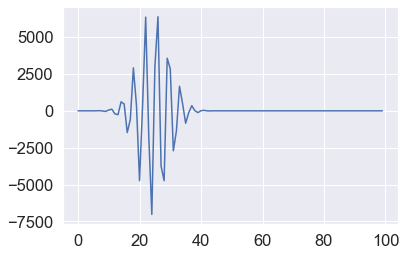

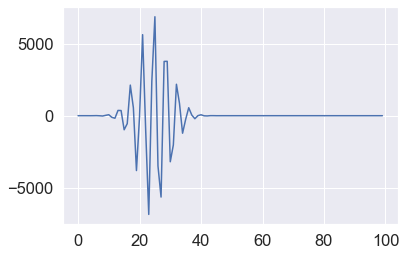

In [38]:
plt.plot(hei[-1])
plt.show()

plt.plot(hei[-1].imag)

C:\Users\astri\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


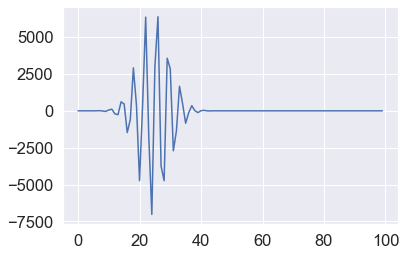

99999


C:\Users\astri\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\astri\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


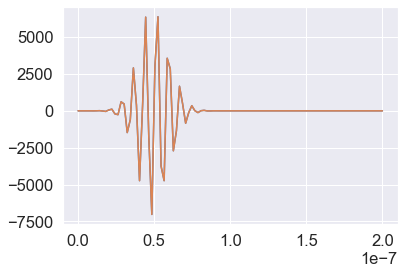

In [37]:
def plot_ksi(t):
    """
    Funksjon for å plotte bølgefunksjonen ksi ved gitt tidspunkt
    
    Inputs
    ------
    t - float
        Tiden vi ønsker å plotte bølgefunksjonen ved
    
    Returns
    -------
        plot av bølgefunksjonen ved gitt tidspunkt
    """
    pass

ff = ksi(x, x0)
plt.plot(ff)
plt.show()

f3 = Phi_neste_tidssteg(x, x0, dt*100000, dt, dx)
plt.plot(x, f3[0])
print(len(f3))
plt.plot(x, f3[-1])
plt.show()

Uttrykket psi I, hva skal det bygge på? Skal det komme av likning 1? Skal det kombineres med likning 4?






## Oppgave 3
Undersøkelse av hvordan innfallsvinkel påvirker nnsynligheten for at elektroner blir transmittert.
Systemet blir beskrevet vha planbølge


Beregne T(E, alpha)

In [7]:
V0 = 0.16  # [eV]
E = np.linspace(0.4, 0.2, 10)  # eV
alpha = np.linspace(0, 30, 10)  # degrees


#E = 0.2
#alpha = 0
m = 9.11 * 1e-31  # mass of electron [kg]
h_bar = 6.582 * 1e-16  # [eV*s]

<ipython-input-8-cb5db207ead2>:28: RuntimeWarning: invalid value encountered in sqrt
  k0_x = np.sqrt(k0_2 - k_y**2)


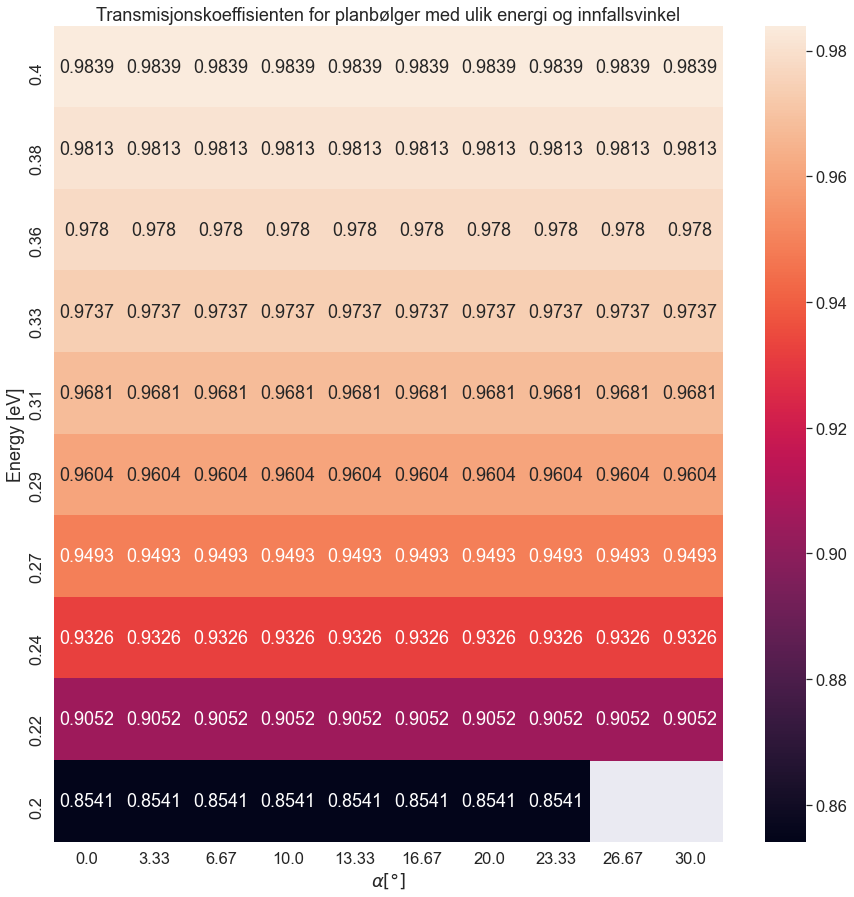

In [8]:
def T(E, V0, alpha):
    """
    Funksjon for å beregne transmisjonskoeffisienten avhengig av energien og
    og innfallsvinkelen til planbølgen. Vil være i intervallet [0,1]
    
    Inputs
    ------
    E - float
        Energi til planbølgen
    V0- float
        Den potensielle energien til potensialtrinnet
    alpha - float
        Innfallsvinkel til planbølgen
    
    Returns
    -------
    float
        Transmisjonskoeffisienten til planbølgen
    """
    T = np.zeros([len(E), len(alpha)])
    _alpha = np.deg2rad(alpha)
    
    for i, _E in enumerate(E):
        k = np.sqrt(2*m*_E) / h_bar  # likn 9
        k_y = k * np.sin(_alpha)  # likn 12
    
        k0_2 = (np.sqrt(2*m*(_E-V0)) / h_bar) **2
        k0_x = np.sqrt(k0_2 - k_y**2)
        k0 = np.sqrt(k0_x**2 + k_y**2)
    
        T[i] = 4 * k * k0 / (k + k0) ** 2
    
    return T

def R(E, alpha):
    """
    Funksjon for å beregne refleksjonskoeffisienten avhengig av energien og
    og innfallsvinkelen til planbølgen. Vil være i intervallet [0,1]
    
    Inputs
    ------
    E - float
        Energi til planbølgen [eV]
    alpha - float
        Innfallsvinkel til planbølgen [grader]
    
    Returns
    -------
    float
        Refleksjonskoeffisienten til planbølgen
    """
    pass

# Regne ut transmisjonskoeffisienten for energi- og alpha-verdier
T_values = T(E, V0, alpha)

# Plotte transmisjonskoeffisienten
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(data=T_values, annot=True, fmt='.4g', xticklabels=alpha.round(2), yticklabels=E.round(2))
ax.set(xlabel=r'$\alpha [\degree]$', ylabel='Energy [eV]', title='Transmisjonskoeffisienten for planbølger med ulik energi og innfallsvinkel')
plt.show()

Når alpha har høy verdi (eks 30 grader) og energien til bølgepakken er lav (eks 0.2 eV) vil utregningen av k0_x gi
NaN. 
k0_x = np.sqrt(k0_2 - k_y ** 2)

Dette er fordi k0^2 - ky^2 < 0. Dermed får vi noe negativt under rottegn.

I praksis betyr dette at for tilstrekkelig høye vinklerer sannsynligheten for at partikkelen transmitteres lik 0. Det er dermed totalrefleksjon for disse vinklene

# SPØRSMÅL ONSDAG:
I praksis så vil det si at alt reflekteres og ingenting transmitteres(?). Teoretisk sett, hva vil det si at vi får et komplekst tall for transmisjonskoeffisienten?

Hvem har skrevet teksten til obligen?? (mtp kilde)